# Машинное обучение
## Никитина Мария
### Б05-003

Далее я привожу модели, которые пробовала. Если нужен только лучший результат, можно сразу перейти к части с линейной регрессией и ElasticNet.

# Библиотеки

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
import optuna

Добавим метрики MAPE и WAPE и функцию подсчёта метрик

In [4]:
def mape(y_true, pred):
    return np.mean(np.abs((y_true - pred) / y_true))

def wape(y_true, pred):
    return np.sum(np.abs(y_true - pred)) / np.sum(y_true)

In [5]:
def dict_metrics(y_true, y_pred):
    metrics = {}
    metrics["MSE"] = round(mean_squared_error(y_true, y_pred), 1)
    metrics["RMSE"] = round(mean_squared_error(y_true, y_pred, squared=False), 1)
    metrics["MAE"] = round(mean_absolute_error(y_true, y_pred), 1)
    # metrics["R2"] = round(r2_score(y_true, y_pred), 3)
    # metrics["Expl_var"] = round(explained_variance_score(y_true, y_pred), 3)
    metrics["MAPE"] = round(mape(y_true, y_pred), 3)
    metrics["WAPE"] = round(wape(y_true, y_pred), 3)
    return metrics

def print_metrics(y_true, y_pred, show_df=True):
    model_metrics = dict_metrics(y_true, y_pred)
    if show_df:
        df = pd.DataFrame(model_metrics, index=[""])
        display(df)
    return model_metrics

# Данные

In [6]:
data = pd.read_csv("/content/drive/MyDrive/fall-ml2-mipt-2023/train.csv")
data = data.drop("Id", axis=1)

In [7]:
data.head()

,Category,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
0,459.509469,-0.328499,1.175144,0.515354,0.293739,0.717413,0.499106,-0.163973,-0.356333,-0.439508,...,-0.069074,0.163611,0.827213,-0.766158,0.628716,0.608708,0.895262,-0.430845,0.222054,-1.378243
1,681.872699,-0.464213,1.104540,-0.489935,-0.956223,-0.280793,0.005371,1.176738,0.158388,0.231923,...,0.528232,0.963157,0.673927,0.271933,-1.245576,0.451102,-0.876329,0.099235,-2.883061,0.219429
2,2087.125600,-1.547788,1.717030,-0.829589,0.661784,-0.537492,0.147143,0.359703,-0.163511,0.840473,...,-1.871161,1.509097,-0.330102,-1.290021,-0.313704,0.064516,1.056933,1.029114,-1.197726,0.317935
3,663.957725,0.351038,-0.070387,0.253418,-0.199843,-0.811106,0.338446,0.658384,0.808466,-0.990371,...,0.065048,0.333310,-1.605971,0.963046,-1.889288,-1.079422,-0.695426,0.096945,-1.142165,0.377868
4,2903.251134,-1.081837,-2.220129,0.422766,-2.795604,-1.065393,-0.378428,0.929238,-0.381571,-1.757911,...,-1.322272,0.352543,-1.292785,-1.270267,0.762935,-0.784592,1.183498,-0.260315,2.517893,0.713963


In [8]:
data.shape

(9000, 101)

<Axes: >

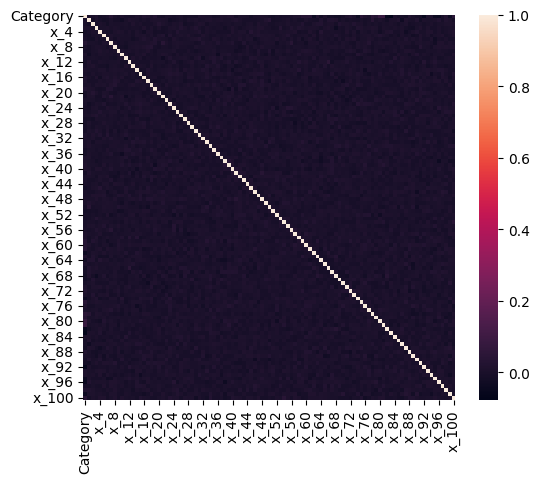

In [12]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr())

In [9]:
data.describe()

,Category,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,2172.374204,-0.022739,0.000500,0.003589,-0.009245,0.020306,0.016148,0.002794,-0.009590,0.000053,...,0.003946,-0.006034,-0.003282,0.005568,-0.008233,-0.001826,0.000632,-0.011786,0.003757,-0.002852
std,1815.552523,0.990292,1.013773,1.010587,1.003052,1.003466,0.999175,0.983060,1.002268,1.006076,...,1.000370,0.993412,0.998110,0.998858,1.007250,0.994195,0.995721,0.997440,0.998777,0.995981
min,43.481937,-4.694588,-3.835178,-3.616606,-3.593398,-3.392300,-3.900025,-3.979925,-3.542189,-4.446632,...,-3.759626,-3.484603,-4.375342,-3.646931,-3.853376,-3.795797,-3.738045,-3.186100,-3.414417,-3.452718
25%,677.899261,-0.702694,-0.695012,-0.682311,-0.690307,-0.646643,-0.659786,-0.657217,-0.690992,-0.667514,...,-0.659040,-0.666167,-0.689205,-0.654525,-0.691111,-0.681119,-0.662623,-0.690443,-0.680318,-0.671232
50%,1396.503952,-0.022805,0.000860,0.003587,-0.016115,0.023781,0.002552,0.014052,-0.013190,0.004902,...,0.008153,-0.013504,0.005804,0.005864,0.013766,-0.013827,-0.002096,-0.010410,0.018092,0.001019
75%,3203.820841,0.648036,0.689887,0.684947,0.672127,0.686733,0.687677,0.672715,0.672896,0.671073,...,0.663741,0.654165,0.664937,0.681369,0.677419,0.670932,0.667209,0.650403,0.691771,0.663505
max,9300.641194,3.617444,3.815091,4.285856,3.702588,4.037848,3.844825,3.634985,4.019774,4.241772,...,3.927907,4.437753,3.587081,4.698708,3.709363,3.621699,3.580763,3.940727,3.782982,3.428494


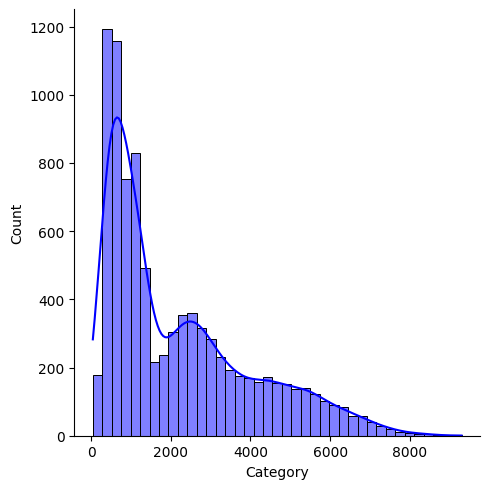

In [10]:
sns.displot(data["Category"], kde=True, color="blue")
plt.show()

Есть подозрение, что фичи сгенерированы из нормального распределения с матожиданием 0 и дисперсией 1. В данных нет выбросов и пропущенных значений. Если посмотреть на график распределения таргета, то можно заметить, что это два нормальных распределения. Больших корреляций между признаками и целевым значением не наблюдается. Значит, есть вероятность, что не получится получить хорошие метрики.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != "Category"],
    data["Category"],
    test_size=0.15,
    shuffle=True
)

# А что, если предсказывать среднее?

In [14]:
mean_preds = np.full(shape=y_test.shape[0], fill_value=data.loc[X_train.index, "Category"].mean())
metrics = print_metrics(y_test, mean_preds)

,MSE,RMSE,MAE,MAPE,WAPE
,3359884.0,1833.0,1512.0,1.529,0.702


# Catboost

Наверное, это модель, которую все в перую очередь хотят попробовать.

In [15]:
model = catboost.CatBoostRegressor(verbose=False)
model.fit(X_train, y_train)

print("TRAIN:")
preds_train = model.predict(X_train)
metrics = print_metrics(y_train, preds_train)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,824635.5,908.1,761.6,0.765,0.35


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3364112.7,1834.2,1529.9,1.563,0.71


Она сильно переобучилась.

# Иерархия

Самое навороченное из того, что я пробовала. Сначала бинарной классификацией предсказываем, больше ли значение, чем 1732 (среднее) или нет. Затем, используя это в качестве ещё одной фичи, получаем предсказание регрессии.

In [18]:
data_class = data.drop("Category", axis=1)
data_class["class"] = data["Category"].apply(lambda x: 1 if x > 1732 else 0)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data_class.loc[:, data_class.columns != "class"],
    data_class["class"],
    test_size=0.15,
    shuffle=True
)

In [21]:
model_bin = catboost.CatBoostClassifier(verbose=False)
model_bin.fit(X_train, y_train)

In [22]:
X_train_new = X_train
X_train_new["class"] = model_bin.predict(X_train)

X_test_new = X_test
X_test_new["class"] = model_bin.predict(X_test)

y_train_new = data.loc[y_train.index, "Category"]
y_test_new = data.loc[y_test.index, "Category"]

In [24]:
model = catboost.CatBoostRegressor(verbose=False)
model.fit(X_train_new, y_train_new)

In [25]:
preds = model.predict(X_test_new)
metrics = print_metrics(y_test_new, preds)

,MSE,RMSE,MAE,MAPE,WAPE
,4921049.2,2218.3,1625.9,1.191,0.714


<ipython-input-29-f7ddc1b8c561>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds, hist=True, kde=False,
<ipython-input-29-f7ddc1b8c561>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_new, hist=True, kde=False,


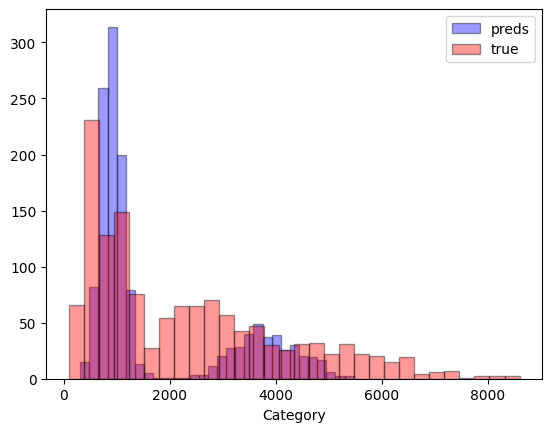

In [29]:
sns.distplot(preds, hist=True, kde=False,
             bins=30, color='blue', hist_kws={'edgecolor':'black'}, label="preds")
sns.distplot(y_test_new, hist=True, kde=False,
             bins=30, color="red", hist_kws={'edgecolor':'black'}, label="true")
plt.legend()
# plt.xlim(left=0, right=3000)
plt.show()

Да, у нас получилось разбить модель на два распределения. Но данные плохие, и зависимости у модели не получается найти. Хотя интересно заметить, что MAPE стал меньше по сравнению с обычным Catboost. На kaggle иерархия набрала 2250.48.

# Деревья

Дисперсия большая, если min_samples_leaf маленький. Смещение большое, если min_samples_leaf большой. На kaggle RandomForest набрал 1730.75.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != "Category"],
    data["Category"],
    test_size=0.15,
    shuffle=True
)

In [39]:
model = RandomForestRegressor(min_samples_leaf=10)
model.fit(X_train, y_train)

print("TRAIN:")
preds = model.predict(X_train)
metrics = print_metrics(y_train, preds)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,1469047.7,1212.0,994.5,1.011,0.46


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3422456.5,1850.0,1531.3,1.485,0.683


In [40]:
model = RandomForestRegressor(min_samples_leaf=100)
model.fit(X_train, y_train)

print("TRAIN:")
preds = model.predict(X_train)
metrics = print_metrics(y_train, preds)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,2892343.6,1700.7,1414.1,1.439,0.655


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3431335.6,1852.4,1531.0,1.474,0.683


# SGDRegressor

На kaggle скор 1717.61. Чем проще модель, тем лучше предсказывает.

In [48]:
model = SGDRegressor()
model.fit(X_train, y_train)

print("TRAIN:")
preds = model.predict(X_train)
metrics = print_metrics(y_train, preds)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,3166890.8,1779.6,1490.0,1.522,0.684


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3141522.8,1772.4,1480.6,1.516,0.691


# Линейная регрессия и ElasticNet

Победители. ElasticNet выбираем, потому что можно попробовать подобрать его параметры. Скор на Kaggle LinearRegression: 1714.59. ElsticNet: 1713.46.

In [49]:
model = LinearRegression()
model.fit(X_train, y_train)

print("TRAIN:")
preds = model.predict(X_train)
metrics = print_metrics(y_train, preds)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,3137399.4,1771.3,1480.4,1.503,0.68


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3114352.5,1764.8,1472.3,1.493,0.687


In [50]:
def objective(trial):
    # зададим пространство поиска гиперпараметров
    param = {}

    param["alpha"] = trial.suggest_float("alpha", 0.01, 10.0)
    param["max_iter"] = trial.suggest_int("max_iter", 100, 3000, step=100)
    param["l1_ratio"] = trial.suggest_float("l1_ratio", 0., 1.)

    # получим предсказания
    model = ElasticNet(**param)
    _ = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # будем уменьшать RMSE
    return -mean_squared_error(y_test, preds, squared=False)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="LinReg", direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# сохраним и выведем лучшие гиперпараметры
trial = study.best_trial
best_param = trial.params
df_best_param = pd.DataFrame(best_param, index=[""])
display(df_best_param)

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,max_iter,l1_ratio
,1.120112,1700,0.925168


In [52]:
model = ElasticNet(**best_param)
model.fit(X_train, y_train)

print("TRAIN:")
preds = model.predict(X_train)
metrics = print_metrics(y_train, preds)

print("TEST:")
preds = model.predict(X_test)
metrics = print_metrics(y_test, preds)

TRAIN:


,MSE,RMSE,MAE,MAPE,WAPE
,3138860.8,1771.7,1480.1,1.504,0.68


TEST:


,MSE,RMSE,MAE,MAPE,WAPE
,3112841.8,1764.3,1471.6,1.495,0.686


# Тест

In [42]:
data_test = pd.read_csv("/content/drive/MyDrive/fall-ml2-mipt-2023/test.csv")
X_test_1 = data_test.drop("Id", axis=1)

In [35]:
X_test_1.shape

(1000, 100)

Предсказания среднего и среднего с шумом

In [ ]:
preds_mean = np.full(shape=1000, fill_value=data["Category"].mean())
# epsilons = np.random.normal(loc=0, scale=0.07 / 3, size=1000)
# preds_mean = preds_mean * (1 + epsilons)

preds_mean = pd.Series(preds_mean)
df = pd.DataFrame({'Id': preds_mean.index, 'Category': preds_mean.values})
df.to_csv('preds_mean.csv', index=False)

Предсказания моделей

In [53]:
preds = model.predict(X_test_1)
preds = pd.Series(preds)
df = pd.DataFrame({'Id': preds.index, 'Category': preds.values})
df.to_csv('preds_ElasticNet.csv', index=False)